In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, f1_score, recall_score, matthews_corrcoef, make_scorer, accuracy_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

In [2]:
def metrics(clf,X,y,pred):
  probabilities = clf.predict_proba(X)

  acc = accuracy_score(y, pred)
  auc = roc_auc_score(y, probabilities, multi_class='ovo', average='macro')
  f1 = f1_score(y, pred, average='macro')
  mcc = matthews_corrcoef(y, pred)
  recall = recall_score(y, pred, average='macro')

  print(f"Decision Tree Accuracy: {acc:.2f}")
  print(f"Decision Tree AUC: {auc:.2f}")
  print(f"Decision Tree F1 Score: {f1:.2f}")
  print(f"Decision Tree MCC: {mcc:.2f}")
  print(f"Decision Tree Recall: {recall:.2f}")

In [3]:
data = pd.read_csv("Threats (1).csv")
data.drop("service", axis=1, inplace=True)

In [4]:
data.proto = LabelEncoder().fit_transform(data.proto)
data.state = LabelEncoder().fit_transform(data.state)
label_encoder = LabelEncoder()
data.attack_cat = label_encoder.fit_transform(data.attack_cat)

In [6]:
X = data.drop("attack_cat", axis=1)
y = data.attack_cat

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [8]:
print(f"Missing values in X: {X.isna().sum().sum()}")

Missing values in X: 0


In [9]:
param_grid = {'max_depth': np.arange(1, 21)}

In [10]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=77, class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
optimal_depth = grid_search.best_params_['max_depth']
print(f"Optimal max_depth: {optimal_depth}")

Optimal max_depth: 20


In [11]:
clf_optimal = DecisionTreeClassifier(max_depth=optimal_depth, random_state=77, class_weight='balanced')
clf_optimal.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=77)

In [12]:
predictions_optimal = clf_optimal.predict(X_test)
acc_optimal = accuracy_score(y_test, predictions_optimal)
print(f"Accuracy with optimal max_depth ({optimal_depth}): {acc_optimal:.2f}")

Accuracy with optimal max_depth (20): 0.77


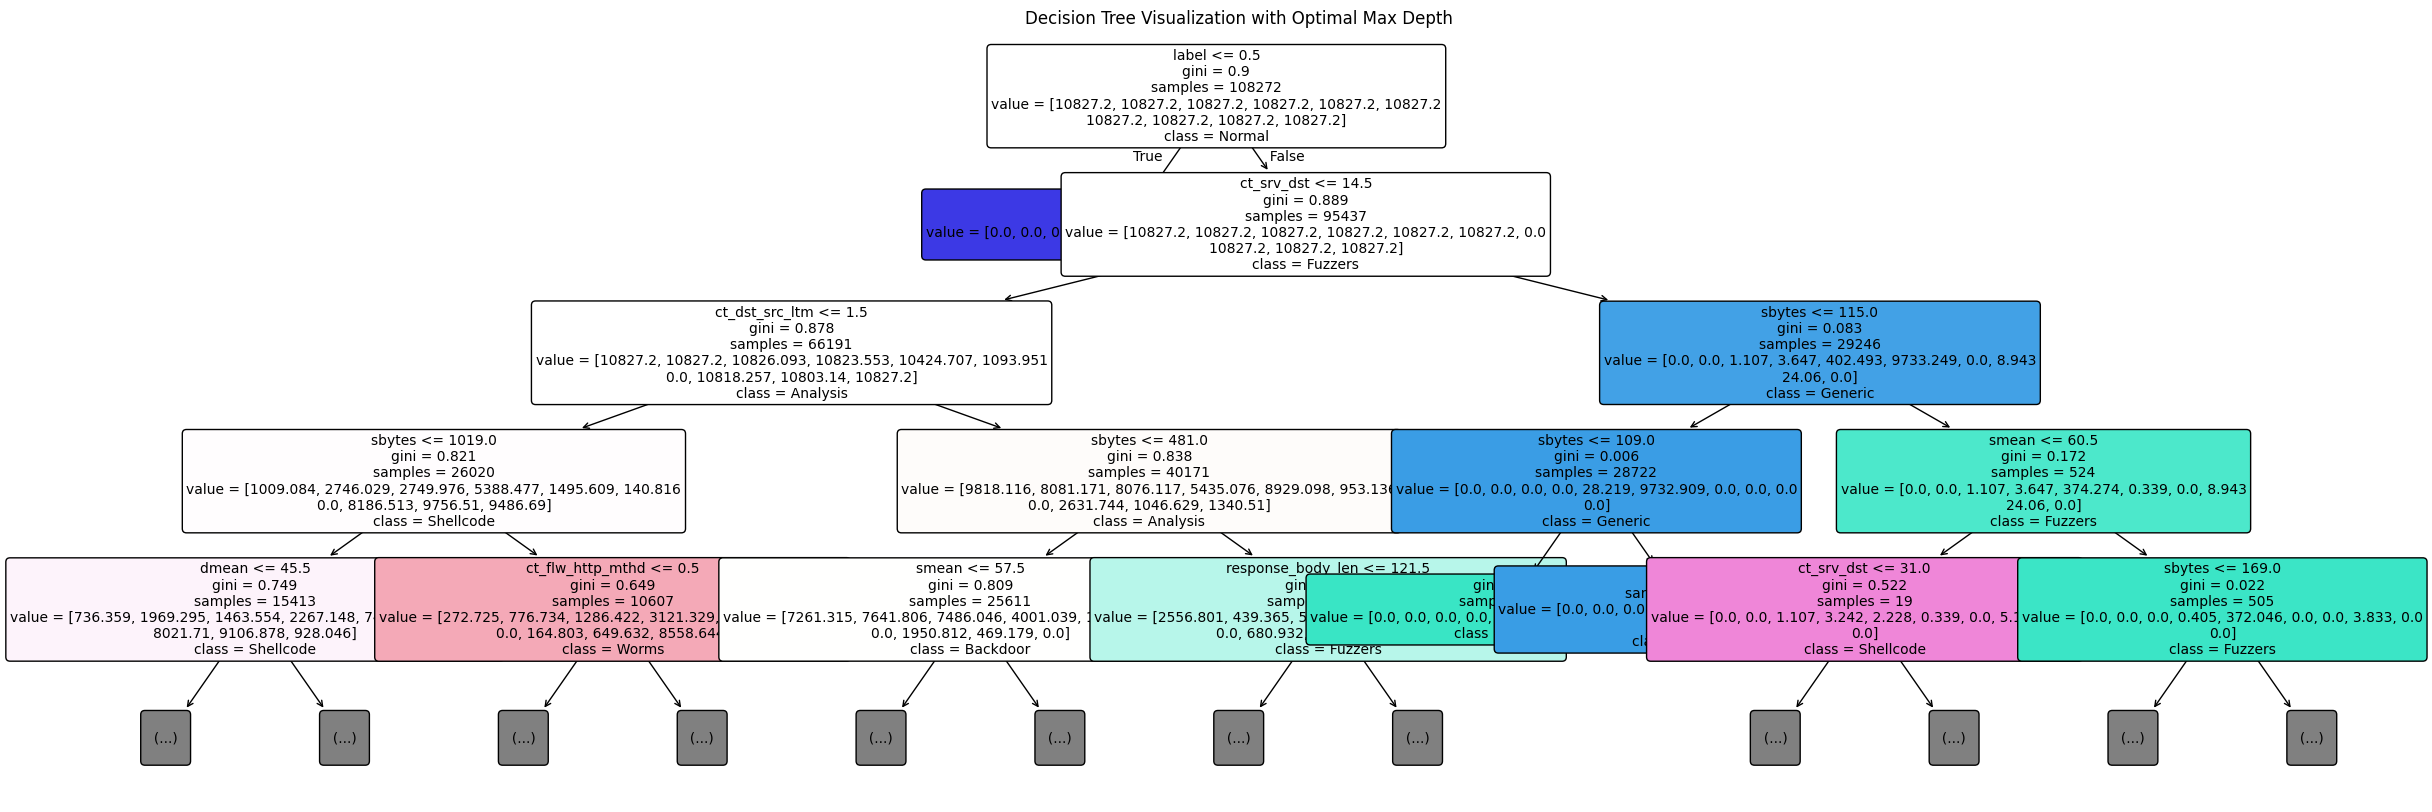

In [13]:
plt.figure(figsize=(30, 10))
plot_tree(
    clf_optimal,
    feature_names=X_train.columns,
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4  # You can adjust this for visualization purposes
)
plt.title("Decision Tree Visualization with Optimal Max Depth")
plt.show()

In [14]:
metrics(clf_optimal, X_test, y_test, predictions_optimal)

Decision Tree Accuracy: 0.77
Decision Tree AUC: 0.88
Decision Tree F1 Score: 0.61
Decision Tree MCC: 0.73
Decision Tree Recall: 0.67


In [15]:
bag_clf = BaggingClassifier(clf_optimal, n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
predictions_bag = bag_clf.predict(X_test)

In [16]:
metrics(bag_clf, X_test, y_test, predictions_bag)

Decision Tree Accuracy: 0.79
Decision Tree AUC: 0.90
Decision Tree F1 Score: 0.43
Decision Tree MCC: 0.74
Decision Tree Recall: 0.44


In [19]:
ada_clf = AdaBoostClassifier(bag_clf, n_estimators=200, algorithm="SAMME", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
predictions_ada = ada_clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


In [20]:
metrics(ada_clf, X_test, y_test, predictions_ada)

Decision Tree Accuracy: 0.79
Decision Tree AUC: 0.74
Decision Tree F1 Score: 0.44
Decision Tree MCC: 0.75
Decision Tree Recall: 0.44
